<a href="https://colab.research.google.com/drive/1775EEIjqRLDD2fgrlcVbV54M_Fw2bVeL" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import useful libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

In [ ]:
import tensorflow
print (tensorflow.__version__)

2.3.0


# Download and show Data

Training data shapes: X=(60000, 28, 28), y=(60000,)
Testing data shapes: X=(10000, 28, 28), y=(10000,)


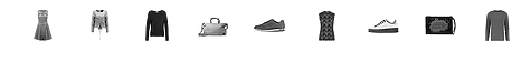

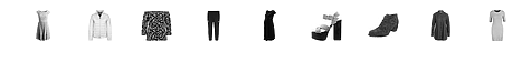

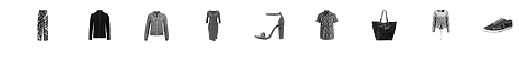

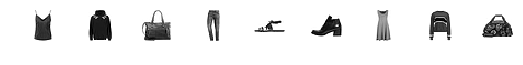

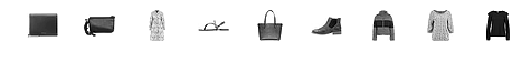

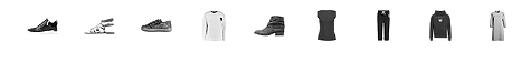

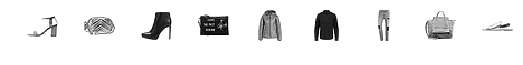

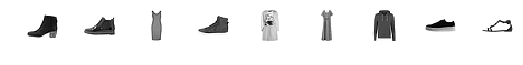

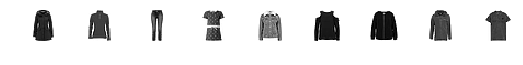

In [ ]:
from tensorflow.keras.datasets import fashion_mnist, mnist

(trainX, trainY), (testX, testY) = fashion_mnist.load_data()

print('Training data shapes: X=%s, y=%s' % (trainX.shape, trainY.shape))
print('Testing data shapes: X=%s, y=%s' % (testX.shape, testY.shape))

for k in range(9):
    plt.figure(figsize=(9, 6))
    for j in range(9):
        i = np.random.randint(0, 10000)
        plt.subplot(990 + 1 + j)
        plt.imshow(trainX[i], cmap='gray_r')
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

# Normalize data

In [ ]:
trainX = [image/255 for image in trainX]
testX = [image/255 for image in testX]

trainX = np.reshape(trainX, (60000, 28, 28, 1))
testX = np.reshape(testX, (10000, 28, 28, 1))

print (trainX.shape, testX.shape, trainY.shape, testY.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1) (60000,) (10000,)


# Define Generator Model

In [ ]:
random_input = tensorflow.keras.layers.Input(shape = 100)

x = tensorflow.keras.layers.Dense(128 * 5 * 5)(random_input)
x = tensorflow.keras.layers.Activation('swish')(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tensorflow.keras.layers.Reshape((5, 5, 128))(x)

x = tensorflow.keras.layers.Conv2DTranspose(filters=128, kernel_size=(5,5))(x)
x = tensorflow.keras.layers.Activation('swish')(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tensorflow.keras.layers.Conv2DTranspose(filters=128, kernel_size=(7,7))(x)
x = tensorflow.keras.layers.Activation('swish')(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tensorflow.keras.layers.Conv2DTranspose(filters=128, kernel_size=(7,7))(x)
x = tensorflow.keras.layers.Activation('swish')(x)

x = tensorflow.keras.layers.Conv2DTranspose(filters=1, kernel_size=(8,8))(x)
generated_image = tensorflow.keras.layers.Activation('sigmoid')(x)

generator_network = tensorflow.keras.models.Model(inputs=random_input, outputs=generated_image)
generator_network.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 3200)              323200    
_________________________________________________________________
activation (Activation)      (None, 3200)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 3200)              12800     
_________________________________________________________________
reshape (Reshape)            (None, 5, 5, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 9, 9, 128)         409728    
_________________________________________________________________
activation_1 (Activation)    (None, 9, 9, 128)        

# Define Discriminator

In [ ]:
image_input = tensorflow.keras.layers.Input(shape=(28, 28, 1))

x = tensorflow.keras.layers.Conv2D(filters=128, kernel_size=(3,3))(image_input)
x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)

x = tensorflow.keras.layers.Conv2D(filters=128, kernel_size=(5,5), strides=2)(x)
x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tensorflow.keras.layers.Conv2D(filters=128, kernel_size=(5,5))(x)
x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tensorflow.keras.layers.Conv2D(filters=64, kernel_size=(7,7))(x)
x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tensorflow.keras.layers.Flatten()(x)

x = tensorflow.keras.layers.Dense(1)(x)
real_vs_fake_output = tensorflow.keras.layers.Activation('sigmoid')(x)

discriminator_network = tensorflow.keras.models.Model(inputs=image_input, outputs=real_vs_fake_output)
discriminator_network.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 128)       1280      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 128)       409728    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 11, 11, 128)       0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 11, 11, 128)       512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)        

In [ ]:
adam_optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
discriminator_network.compile(loss='binary_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])

# Define combined model : DCGAN

In [ ]:
discriminator_network.trainable=False

g_output = generator_network(random_input)
d_output = discriminator_network(g_output)

dcgan_model = tensorflow.keras.models.Model(random_input, d_output)
dcgan_model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
functional_1 (Functional)    (None, 28, 28, 1)         2360833   
_________________________________________________________________
functional_3 (Functional)    (None, 1)                 1223553   
Total params: 3,584,386
Trainable params: 2,353,921
Non-trainable params: 1,230,465
_________________________________________________________________


# Compiling DCGAN

In [ ]:
dcgan_model.compile(loss='binary_crossentropy', optimizer=adam_optimizer)

# Define Data Generators

In [ ]:
indices = [i for i in range(0, len(trainX))]

def get_random_noise(batch_size, noise_size):
    random_values = np.random.randn(batch_size*noise_size)
    random_noise_batch = np.reshape(random_values, (batch_size, noise_size))
    return random_noise_batch

def get_fake_samples(generator_network, batch_size, noise_size):
    random_noise_batch = get_random_noise(batch_size, noise_size) 
    fake_samples = generator_network.predict_on_batch(random_noise_batch)
    return fake_samples

def get_real_samples(batch_size):
    random_indices = np.random.choice(indices, size=batch_size)
    real_images = trainX[np.array(random_indices),:]
    return real_images

def show_generator_results(generator_network):
    for k in range(9):
        plt.figure(figsize=(7, 7))
        fake_samples = get_fake_samples(generator_network, 9, noise_size)
        for j in range(9):
            plt.subplot(990 + 1 + j)
            plt.imshow(fake_samples[j,:,:,-1], cmap='gray_r')
            plt.axis('off')
            #plt.title(trainY[i])
        plt.show()
    return

# Training DCGAN

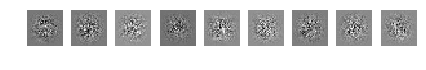

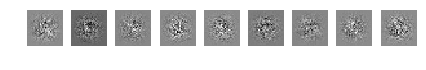

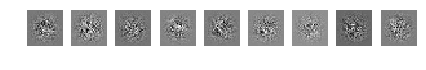

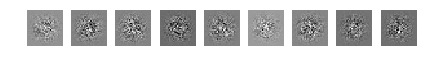

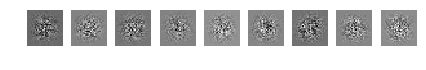

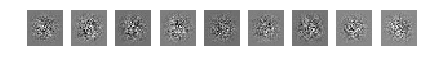

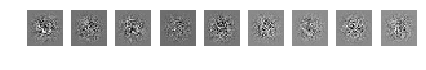

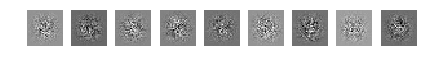

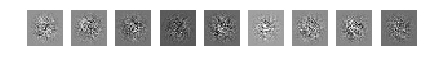

Epoch:0, Step:0, D-Loss:0.877, D-Acc:26.000, G-Loss:0.671
Epoch:0, Step:50, D-Loss:0.050, D-Acc:99.000, G-Loss:3.340
Epoch:0, Step:100, D-Loss:0.143, D-Acc:95.000, G-Loss:4.904
Epoch:0, Step:150, D-Loss:0.052, D-Acc:99.000, G-Loss:6.281
Epoch:0, Step:200, D-Loss:0.057, D-Acc:99.000, G-Loss:4.779
Epoch:0, Step:250, D-Loss:0.237, D-Acc:88.000, G-Loss:2.961
Epoch:0, Step:300, D-Loss:0.067, D-Acc:99.000, G-Loss:5.256
Epoch:0, Step:350, D-Loss:0.177, D-Acc:91.000, G-Loss:10.000
Epoch:0, Step:400, D-Loss:0.063, D-Acc:99.000, G-Loss:6.597
Epoch:0, Step:450, D-Loss:0.063, D-Acc:98.000, G-Loss:3.309


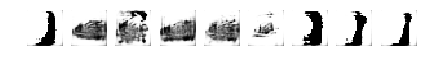

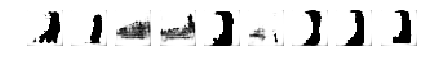

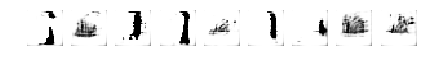

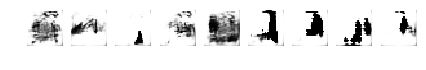

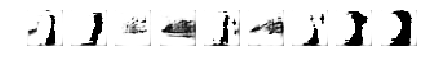

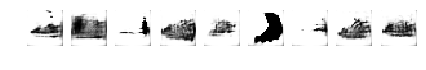

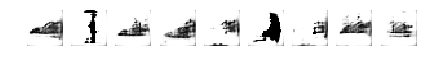

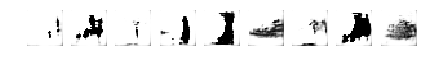

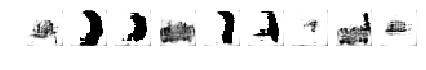

Epoch:1, Step:0, D-Loss:0.086, D-Acc:98.000, G-Loss:4.552
Epoch:1, Step:50, D-Loss:0.143, D-Acc:95.000, G-Loss:3.850
Epoch:1, Step:100, D-Loss:0.159, D-Acc:95.000, G-Loss:9.808
Epoch:1, Step:150, D-Loss:0.078, D-Acc:98.000, G-Loss:3.067
Epoch:1, Step:200, D-Loss:0.061, D-Acc:99.000, G-Loss:6.220
Epoch:1, Step:250, D-Loss:0.132, D-Acc:96.000, G-Loss:3.171
Epoch:1, Step:300, D-Loss:0.142, D-Acc:93.000, G-Loss:1.294
Epoch:1, Step:350, D-Loss:0.104, D-Acc:97.000, G-Loss:1.532
Epoch:1, Step:400, D-Loss:0.205, D-Acc:92.000, G-Loss:2.682
Epoch:1, Step:450, D-Loss:0.197, D-Acc:91.000, G-Loss:1.820


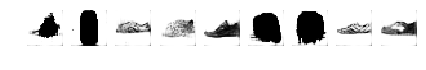

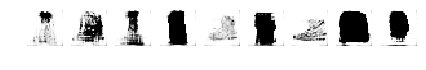

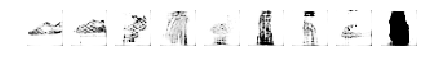

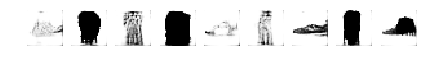

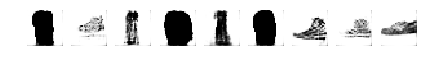

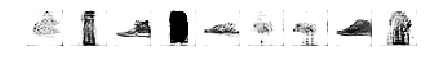

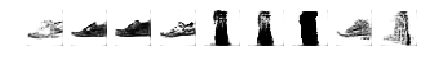

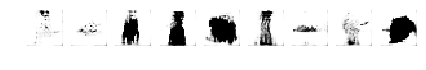

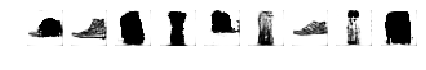

Epoch:2, Step:0, D-Loss:0.143, D-Acc:94.000, G-Loss:1.874
Epoch:2, Step:50, D-Loss:0.138, D-Acc:95.000, G-Loss:1.778
Epoch:2, Step:100, D-Loss:0.148, D-Acc:94.000, G-Loss:4.225
Epoch:2, Step:150, D-Loss:0.208, D-Acc:91.000, G-Loss:8.705
Epoch:2, Step:200, D-Loss:0.154, D-Acc:94.000, G-Loss:2.030
Epoch:2, Step:250, D-Loss:0.124, D-Acc:95.000, G-Loss:1.908
Epoch:2, Step:300, D-Loss:0.112, D-Acc:96.000, G-Loss:4.391
Epoch:2, Step:350, D-Loss:0.156, D-Acc:95.000, G-Loss:2.621
Epoch:2, Step:400, D-Loss:0.150, D-Acc:94.000, G-Loss:1.393
Epoch:2, Step:450, D-Loss:0.197, D-Acc:93.000, G-Loss:1.032


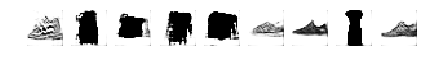

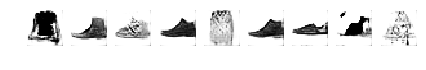

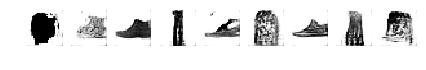

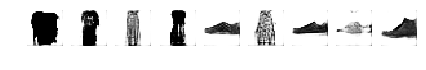

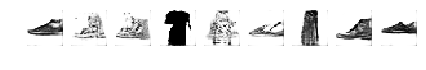

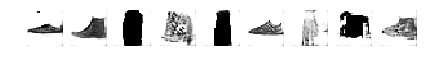

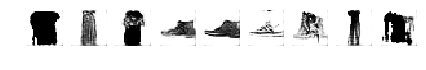

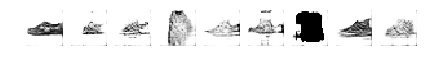

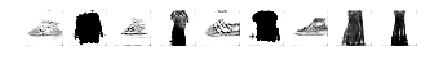

Epoch:3, Step:0, D-Loss:0.179, D-Acc:93.000, G-Loss:3.576
Epoch:3, Step:50, D-Loss:0.269, D-Acc:89.000, G-Loss:2.972
Epoch:3, Step:100, D-Loss:0.208, D-Acc:89.000, G-Loss:8.588
Epoch:3, Step:150, D-Loss:0.229, D-Acc:95.000, G-Loss:4.458
Epoch:3, Step:200, D-Loss:0.143, D-Acc:96.000, G-Loss:0.778
Epoch:3, Step:250, D-Loss:0.207, D-Acc:94.000, G-Loss:1.552
Epoch:3, Step:300, D-Loss:0.209, D-Acc:89.000, G-Loss:1.142
Epoch:3, Step:350, D-Loss:0.278, D-Acc:88.000, G-Loss:2.996
Epoch:3, Step:400, D-Loss:0.185, D-Acc:92.000, G-Loss:3.426
Epoch:3, Step:450, D-Loss:0.191, D-Acc:91.000, G-Loss:2.303


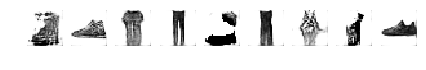

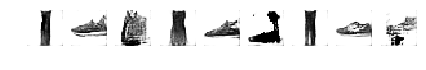

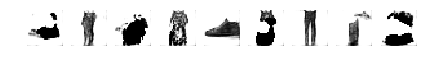

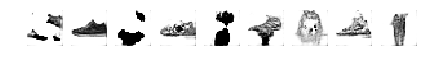

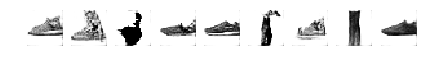

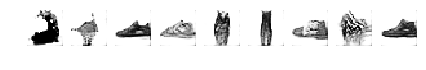

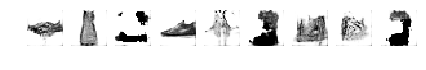

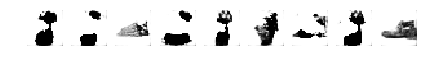

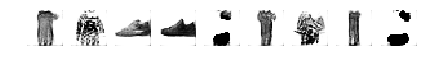

Epoch:4, Step:0, D-Loss:0.234, D-Acc:90.000, G-Loss:7.422
Epoch:4, Step:50, D-Loss:0.249, D-Acc:90.000, G-Loss:9.823
Epoch:4, Step:100, D-Loss:0.135, D-Acc:95.000, G-Loss:7.880
Epoch:4, Step:150, D-Loss:0.234, D-Acc:92.000, G-Loss:11.205
Epoch:4, Step:200, D-Loss:0.185, D-Acc:91.000, G-Loss:2.766
Epoch:4, Step:250, D-Loss:0.142, D-Acc:95.000, G-Loss:2.359
Epoch:4, Step:300, D-Loss:0.235, D-Acc:92.000, G-Loss:4.195
Epoch:4, Step:350, D-Loss:0.100, D-Acc:97.000, G-Loss:2.530
Epoch:4, Step:400, D-Loss:0.084, D-Acc:99.000, G-Loss:8.284
Epoch:4, Step:450, D-Loss:0.169, D-Acc:93.000, G-Loss:5.002


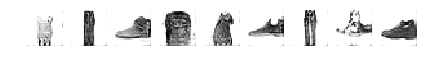

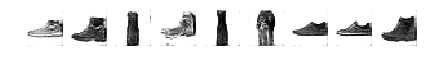

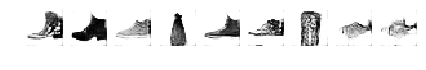

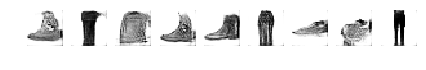

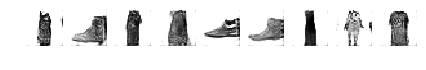

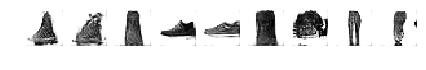

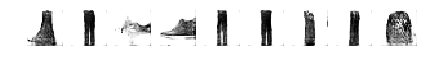

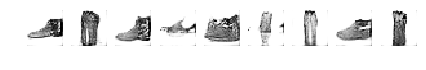

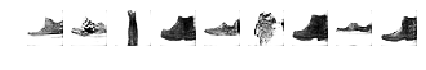

Epoch:5, Step:0, D-Loss:0.156, D-Acc:95.000, G-Loss:5.921
Epoch:5, Step:50, D-Loss:0.238, D-Acc:93.000, G-Loss:1.169
Epoch:5, Step:100, D-Loss:0.173, D-Acc:94.000, G-Loss:0.471
Epoch:5, Step:150, D-Loss:0.221, D-Acc:92.000, G-Loss:4.090
Epoch:5, Step:200, D-Loss:0.174, D-Acc:92.000, G-Loss:4.953
Epoch:5, Step:250, D-Loss:0.283, D-Acc:89.000, G-Loss:0.659
Epoch:5, Step:300, D-Loss:0.210, D-Acc:94.000, G-Loss:7.285
Epoch:5, Step:350, D-Loss:0.198, D-Acc:90.000, G-Loss:1.324
Epoch:5, Step:400, D-Loss:0.170, D-Acc:92.000, G-Loss:1.308
Epoch:5, Step:450, D-Loss:0.361, D-Acc:82.000, G-Loss:5.334


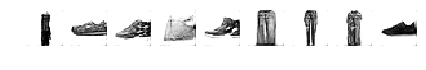

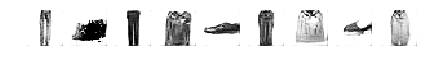

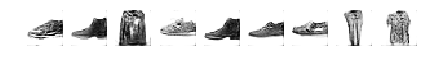

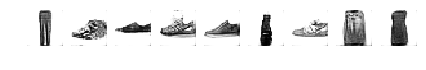

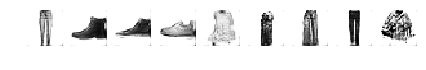

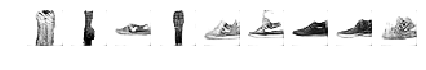

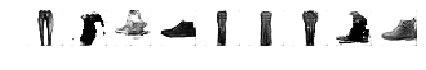

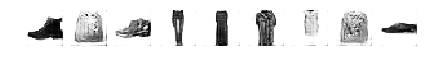

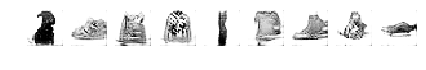

Epoch:6, Step:0, D-Loss:0.169, D-Acc:93.000, G-Loss:0.504
Epoch:6, Step:50, D-Loss:0.374, D-Acc:86.000, G-Loss:3.713
Epoch:6, Step:100, D-Loss:0.226, D-Acc:93.000, G-Loss:4.940
Epoch:6, Step:150, D-Loss:0.268, D-Acc:87.000, G-Loss:7.279
Epoch:6, Step:200, D-Loss:0.260, D-Acc:90.000, G-Loss:8.870
Epoch:6, Step:250, D-Loss:0.270, D-Acc:91.000, G-Loss:5.265
Epoch:6, Step:300, D-Loss:0.283, D-Acc:86.000, G-Loss:3.226
Epoch:6, Step:350, D-Loss:0.190, D-Acc:94.000, G-Loss:1.719


In [ ]:
epochs = 20
batch_size = 100
steps = 500
noise_size = 100

for i in range(0, epochs):
    show_generator_results(generator_network)
    for j in range(steps):
        fake_samples = get_fake_samples(generator_network, batch_size//2, noise_size)
        real_samples = get_real_samples(batch_size=batch_size//2)

        fake_y = np.zeros((batch_size//2, 1))
        real_y = np.ones((batch_size//2, 1))
        
        input_batch = np.vstack((fake_samples, real_samples))
        output_labels = np.vstack((fake_y, real_y))
        
        # Updating Discriminator weights
        discriminator_network.trainable=True
        loss_d = discriminator_network.train_on_batch(input_batch, output_labels)
        
        gan_input = get_random_noise(batch_size, noise_size)
        
        # Make the Discriminator belive that these are real samples and calculate loss to train the generator
        gan_output = np.ones((batch_size))
        
        # Updating Generator weights
        discriminator_network.trainable=False
        loss_g = dcgan_model.train_on_batch(gan_input, gan_output)
        
        if j%50 == 0:
            print ("Epoch:%.0f, Step:%.0f, D-Loss:%.3f, D-Acc:%.3f, G-Loss:%.3f"%(i,j,loss_d[0],loss_d[1]*100,loss_g))
            

# Results

In [ ]:
#Generating Unlimited samples
for i in range(5):
    show_generator_results(generator_network)